# STAT 5000 Spring 2020 Project

Instructions: Answer each part of the following questions. You are permitted to collaborate with classmates, but you should ${\bf not}$ copy code or answers from anyone. All work should be your own (perhaps influenced by collaborations). Some questions will require some outside research. I am here to help!

Note that some questions require you to write out explanations and equations. I ${\bf \text{do not}}$ want these parts written by hand and turned in separately. Part of the goal of this project is for you to learn to write (very basic) LaTeX equations in the Markdown cells here in Jupyter (if you haven't done so already). Please see the following link for a tutorial: http://data-blog.udacity.com/posts/2016/10/latex-primer/.

This project will be submitted electronically to Canvas by ${\bf \text{Wednesday, April 29 at 11:59pm.}}$

## Problem 1

#### (a) Load the diabetes dataset (for information about this data set, see https://www.rdocumentation.org/packages/faraway/versions/1.0.7/topics/diabetes).   Construct a new data frame with the stabilized glucose, gender, and frame variables. Report summary statistics. Based on those summaries, further clean the data as necessary.  Use this new data frame on all additional parts of this question.


In [2]:
library(infer)
library(dplyr)
library(ggplot2)
library(faraway)

#load diabetes data into variable data
data <- diabetes
#we only care about stable glucose, gender and frame, so subset those
data <- subset(diabetes, select=c("stab.glu", "gender", "frame"))
#print this summmary, notice the missting values
summary(data)
#keep only the complete cases of the data, remove na values
data <- data[complete.cases(data), ]
#print new summary
summary(data)

    stab.glu        gender       frame    
 Min.   : 48.0   male  :169   small :104  
 1st Qu.: 81.0   female:234   medium:184  
 Median : 89.0                large :103  
 Mean   :106.7                NA's  : 12  
 3rd Qu.:106.0                            
 Max.   :385.0                            

    stab.glu        gender       frame    
 Min.   : 48.0   male  :164   small :104  
 1st Qu.: 81.0   female:227   medium:184  
 Median : 89.0                large :103  
 Mean   :106.5                            
 3rd Qu.:106.0                            
 Max.   :385.0                            

#### (b) Print a boxplot of the stabalized glucose, conditioning on gender. Comment on each distribution. Visually, do you see a difference between the mean stabalized glucose among males and the mean stabalized glucose among females?

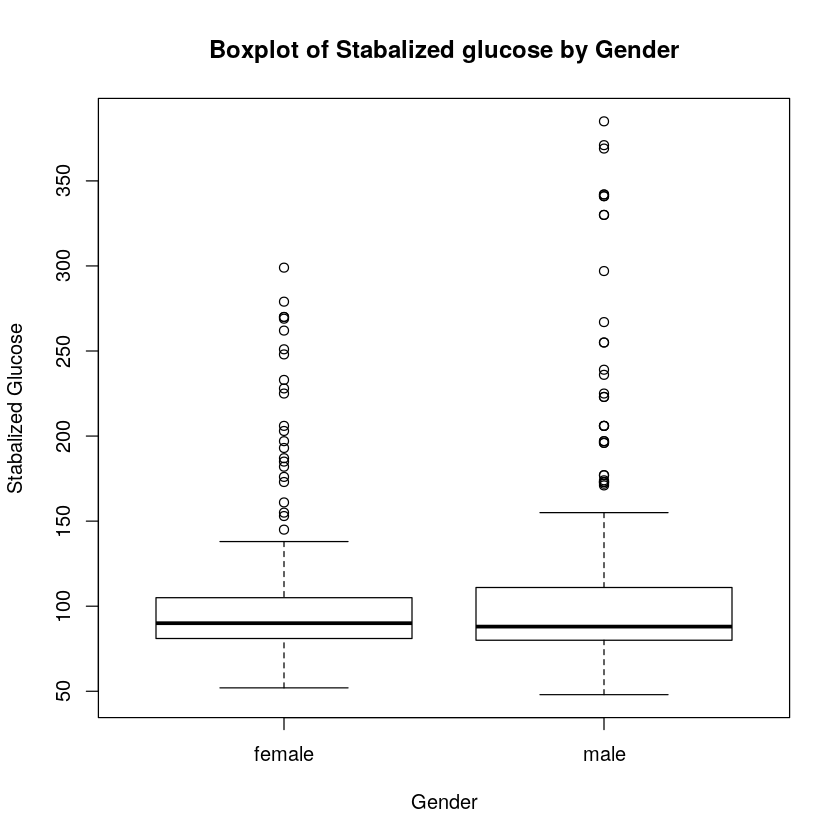

In [3]:
#Get each unique value in gender
uniqueVals <- unique(data$gender)
#for this first iteration of the for loop we need to initialize the conditional distribution (so we can cblind
#later)
k = 0
#for each gender
for (i in uniqueVals){
    #if first iteration
    if(k == 0){
        #input the first entry of the distribution conditioned on gender
        condDist <- data$stab.glu[data$gender == i]
    }
    else{
        #input the other distribution conditions on the other unique values
        condDist <- suppressWarnings(cbind(condDist, data$stab.glu[data$gender == i]))
    }
    #make sure we don't initialize again
    k = 1                               
}
#put in column names for the data
colnames(condDist) <- uniqueVals
#construct the boxplot
boxplot(condDist, 
       main = "Boxplot of Stabalized glucose by Gender",
       ylab="Stabalized Glucose",
    xlab="Gender")

Since the medians of both distributions are approaximately the same, but the male distribution seems to have more skew I think we can visually conclude that the two means are different, with the male mean being pulled toward a higher value due to skew

#### (c) Formally test the hypothesis that there is no difference in mean stable glucose across males and females. Report the p-value and what hypothesis you would act as though is true.

In [4]:
#Set seed for reproducability
set.seed(10)
#Using simulation:
#NOTE: we could do a one sided p-value since we think males have a higher stable glucose, but I will still do a 
#two sided test since that is more conservative

#get the difference in means that we observed
diff_mean_obs <- data%>%group_by(gender)%>%summarize(meanGen = mean(stab.glu))%>%pull(meanGen)%>%diff()
#permute data and generate 500 repetitions
perm_data <- data %>% specify(stab.glu~gender) %>%
         hypothesize(null = "independence") %>%
         generate(reps = 500, type = "permute") %>%
         calculate(stat = "diff in means", order = c("female", "male"))

#phat is the proportion of statistics that are more extreme than our observed difference (multiply by 2 for the 
#2 sided test)
p_hat <- perm_data%>%summarize(p_hat_simulated = 2*mean(stat <= diff_mean_obs))
print("results of simulation:")
p_hat
#Using t-distribution:
print("results of a t-test:")
t.test(stab.glu~gender, data = data, null = 0)

[1] "results of simulation:"


p_hat_simulated
0.116


[1] "results of a t-test:"



	Welch Two Sample t-test

data:  stab.glu by gender
t = 1.5712, df = 270.59, p-value = 0.1173
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.294434 20.429440
sample estimates:
  mean in group male mean in group female 
            111.7988             102.7313 


This means that there is a 11.6% chance of getting the observed difference in means if the null hypothesize is true. This means that we cannot reject the null because our p value is greater than .05, so we would accept the null hypothesis that there is no difference in means. 

#### (d) Is the confidence interval for the difference in means consistent with the result of the test? Explain.

In [5]:
#use bootstrapping to simulate 500 samples that are still properly centered
bootData <- data %>%
                    specify((stab.glu~gender))%>%
                    generate(reps = 500, type = "bootstrap")%>%
                    calculate(stat = "diff in means", order = c("male", "female"))
#for 95% confidence we want the .025 quantile and the .975 quantile of our simulated data
confInterval <- bootData%>%summarize(lower = quantile(stat, p = .025), upper = quantile(stat, p = .975))
confInterval

lower,upper
-2.349764,20.84569


This confidence interval is consistant with our results from the hypothesis test, because 0 is included in the confidence interval, so we cannot definitively reject the null, because the true value may very well be zero.

#### (e) Now, construct a boxplot of stable gluecose, conditioning on frame. Comment on each distribution. Visually, do you see a difference between the mean stabalized glucose among people of different frame sizes?

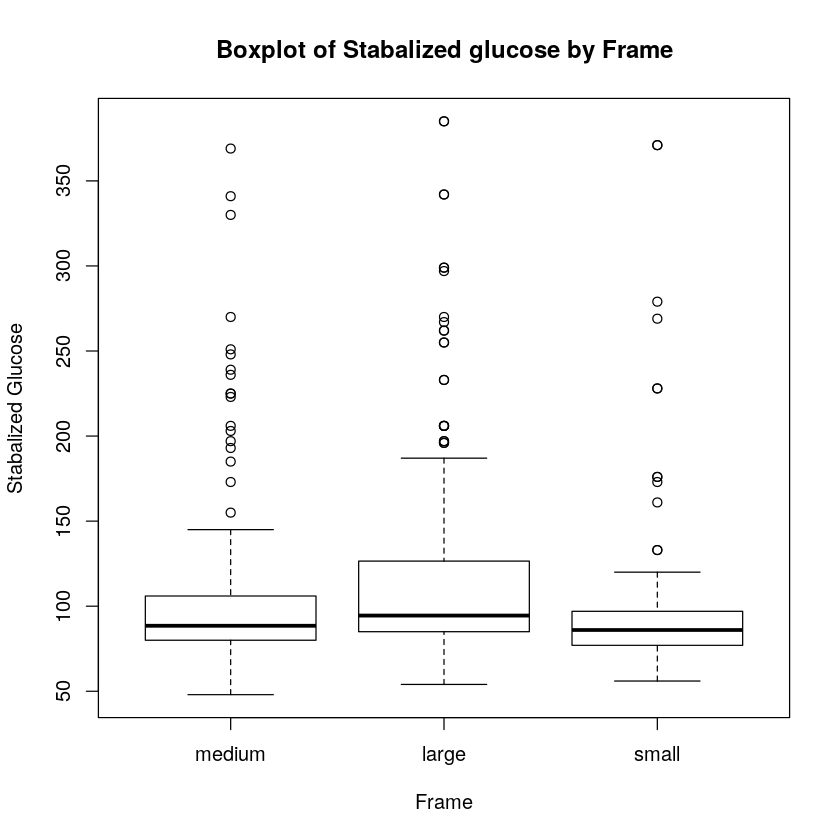

In [6]:
#Construct another conditional boxplot simular in logic to the one above
uniqueVals <- unique(data$frame)
k = 0
for (i in uniqueVals){
    if(k == 0){
        condDist <- data$stab.glu[data$frame == i]
    }
    else{
        condDist <- suppressWarnings(cbind(condDist, data$stab.glu[data$frame == i]))
    }
    k = 1                                              
}
colnames(condDist) <- uniqueVals
boxplot(condDist, 
       main = "Boxplot of Stabalized glucose by Frame",
       ylab="Stabalized Glucose",
    xlab="Frame")

Medium and small almost look the same, but you can see that there are more outliers in the medium population which might skew the mean upwards, the median of large frames is visually larger than that of small or medium, and its interquartile range appears to contain higher values than either small or medium, so we might expect that large frame has a larger mean stabalized glucose than small or medium frames.

(f) Let's now conduct an analysis to more formally decide whether there is difference among means of stable gluecose across people of different frame sizes (the technique that we will use is called Analysis of Variance (ANOVA)). We fit a linear model 

\begin{equation}
Y_i = \beta_0 + \beta_1X_{i,m} + \beta_2X_{i,s} + \varepsilon_i, \,\,\, i = 1,...,n \,\,\,\,\,\,\,\ (1)
\end{equation}

where

1. $\varepsilon_i \sim \mathcal{N}(0, \sigma^2)$;

2. $
 X_{i,m}= 
\begin{cases}
1 \,\,\, \text{ if the } i^{th} \text{ measurement is in the "medium" group.} \\
0 \,\,\, \text{otherwise}
\end{cases};
$

3. $
 X_{i,s}= 
\begin{cases}
1 \,\,\, \text{ if the } i^{th} \text{ measurement is in the "small" group.} \\
0 \,\,\, \text{otherwise}
\end{cases};
$
and
4. $Y_i$ is the $i^{th}$ measurement of stable glucose.

 
#### (i) Write down the model for stable glucose for individuals in the large framed group.

$Y_i=\beta_0+\epsilon_i$

#### (ii) Fit the model in equation (1) above. [HINT: The easiest way to do this is something like ${\tt lm(response \sim predictor, data = data)}$, where the predictor is the categorical variable in the dataset.] Is there a statistically significant difference among means of stable glucose across people of different frame sizes?

In [8]:
#construct a linear model
summary(lm(stab.glu~frame, data = data))


Call:
lm(formula = stab.glu ~ frame, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-67.204 -26.632 -15.204   1.529 275.029 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   95.971      5.154  18.622  < 2e-16 ***
framemedium    8.322      6.448   1.291 0.197565    
framelarge    25.233      7.306   3.454 0.000614 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 52.56 on 388 degrees of freedom
Multiple R-squared:  0.03135,	Adjusted R-squared:  0.02636 
F-statistic:  6.28 on 2 and 388 DF,  p-value: 0.00207


We can see that both the intercept (small frame) and large frame have statistically significant coefficients which says that each of them have a statistically significant difference in mean stable glucose, but medium frame does not have a statistically significant difference in stable glucose since its coefficient is not labeled as statistically significant.

#### (iii) What is the mean stable glucose value for a person with a large frame? Medium frame? How much higher or lower is the stable glucose of a small framed person than a large framed person?

To start we need to rewrite our model since it is using frame large and frame medium, but we would like it to use frame small:  
$$  
currentModel = 95.971+8.322*framemedium+25.233*framelarge
$$  
to start we would like to get the same exact behavior of the model, but with framelarge as the intercept, so, if frame == large we would get:  
$$  
currentModel(frame = large) = 95.971+25.233 = 121.204
$$  
Which will be the the $\beta_0$ term in our new model. Then if frame = medium we would have:  
$$  
currentModel(frame = medium) = 95.971+8.322 = 104.293
$$  
We would like our new model to equal this when frame = medium, so: $121.204 +\beta_1 = 104.293 => \beta_1 = -16.911$. Simularly we can derive $\beta_2 = 95.971 - 121.204 = -25.233$. So we get the model in the correct form as:  
$$
newModel = 121.204-16.911*X_{i,m}-25.233*X_{i,s}
$$  
**Expected value for large frame:**
$E(Y_{large}) = E(\beta_0+\epsilon_i) = \beta_0 = 121.204$. We get this result becuase the expect value of $\epsilon_i = 0$ for all i  
**Expected value for medium frame:**
$E(Y_{medium}) = E(\beta_0+\beta_1+\epsilon_i) = \beta_0 - \beta_1 = 121.204-16.911 = 104.293$  
**Expected value for small frame:**
$E(Y_{small}) = E(\beta_0+\beta_2+\epsilon_i) = \beta_0 - \beta_2 = 121.204-16.911 = 95.971$  
On average, a small framed person has $121.204-95.971 = 25.233$ less stable glucose than a large framed person.

## Problem 2

The World Happiness Report is a landmark survey of the state of global happiness. The first report was published in 2012, the second in 2013, the third in 2015, and the fourth in the 2016 Update. The World Happiness 2017, which ranks 155 countries by their happiness levels, was released at the United Nations at an event celebrating International Day of Happiness on March 20th. The report continues to gain global recognition as governments, organizations and civil society increasingly use happiness indicators to inform their policy-making decisions. Leading experts across fields – economics, psychology, survey analysis, national statistics, health, public policy and more – describe how measurements of well-being can be used effectively to assess the progress of nations. The reports review the state of happiness in the world today and show how the new science of happiness explains personal and national variations in happiness.

Each variable measured reveals a populated-weighted average score on a scale running from 0 to 10 that is tracked over time and compared against other countries. These variables currently include: real GDP per capita, social support, healthy life expectancy, freedom to make life choices, generosity, and perceptions of corruption. Each country is also compared against a hypothetical nation called Dystopia. Dystopia represents the lowest national averages for each key variable and is, along with residual error, used as a regression benchmark.


#### (a) Read in the World Happiness Report data.


In [9]:
data <- read.csv("2017.csv")

#### (b) Load the ${\tt ggplot2 }$ and ${\tt ggcorrplot }$  libraries. Construct a correlation matrix consisting of the happiness score, GDP, Family, life expectancy, freedom, generosity, and trust government corruption (you can do this with the ${\tt corr()}$ function). Then, use that correlation matrix in the ${\tt ggcorrplot}$ function to create a visually pleasing correlation plot. Comment on the relationships between these variables.

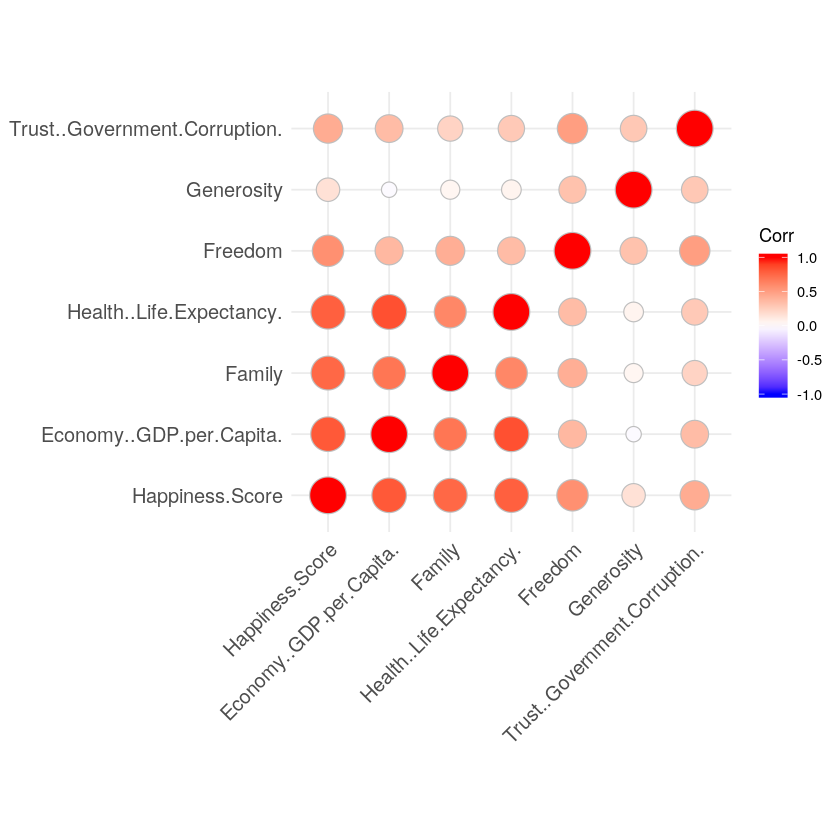

In [10]:
#Load the libraries 
library(ggplot2)
library(ggcorrplot)
#get the correlation matrix between all of the variables of interest
corrMat <- cor(data[,c("Happiness.Score","Economy..GDP.per.Capita.","Family","Health..Life.Expectancy.","Freedom",
           "Generosity","Trust..Government.Corruption.")])
#create a plot of the correlation matrix
ggcorrplot(corrMat, method = "circle")

All correlations in this matrix are positive (or about zero). It seems that the strongest correlations for happiness score are GDP per capita, family, and health life expectancy. None of the correlations in the plot are 1 with any other variable, so none or the variables are directly related (as in none of the variables can be completely described using another variable in the data set).

#### (c) Construct a multiple linear regression model where the happiness score is the response, and the remaining variables used in (b) as predictors. Print a summary of this model. 

In [11]:
#construct the linear model specified by the problem
mod <- lm(Happiness.Score~Economy..GDP.per.Capita.+ Family + Health..Life.Expectancy. + Freedom + 
          Generosity + Trust..Government.Corruption., data = data)
#print the model summary
summary(mod)


Call:
lm(formula = Happiness.Score ~ Economy..GDP.per.Capita. + Family + 
    Health..Life.Expectancy. + Freedom + Generosity + Trust..Government.Corruption., 
    data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.52798 -0.25219 -0.02277  0.28526  1.20417 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     1.7430     0.1874   9.303  < 2e-16 ***
Economy..GDP.per.Capita.        0.7844     0.2045   3.836 0.000185 ***
Family                          1.1178     0.2021   5.532 1.40e-07 ***
Health..Life.Expectancy.        1.2889     0.3215   4.009 9.65e-05 ***
Freedom                         1.4757     0.3425   4.309 2.98e-05 ***
Generosity                      0.3807     0.3293   1.156 0.249524    
Trust..Government.Corruption.   0.8266     0.4843   1.707 0.089975 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4998 on 148 degrees of freedom
Multiple 

#### (d) What is the percent of variability in happiness score that can be explained by GDP, Family, life expectancy, freedom, generosity, and trust government corruption?

In [12]:
print("The percent of variability explained by our model is 100*R^2 or:")
print(100*0.8124)

[1] "The percent of variability explained by our model is 100*R^2 or:"
[1] 81.24


#### (e) Predict the happiness score for a country with (sample) average values for GDP, Family, life expectancy, freedom, generosity, and trust government corruption. 

In [13]:
#get all of the averages that we want to predict on into a dataframe
newdata = data.frame(Economy..GDP.per.Capita. = mean(data$Economy..GDP.per.Capita.), 
                     Family = mean(data$Family), Health..Life.Expectancy. = mean(data$Health..Life.Expectancy.),
                     Health..Life.Expectancy. = mean(data$Health..Life.Expectancy.), 
                     Freedom = mean(data$Freedom), Generosity = mean(data$Generosity), 
                     Trust..Government.Corruption. = mean(data$Trust..Government.Corruption.))
#call predict on the data we want to predict on
predict(mod, newdata = newdata)

1 
5.354019

#### (f) Interpret the coefficient associated with life expectancy.

Life expectancy's coefficient is 1.2889, so we would expect an increase of 1.2889 in happiness score for each increase of 1 in life expectancy after controlling for GDP, Family, freedom, generosity, and trust government corruption.

#### (g) Assess the multiple linear regression assumptions. Are any of them violated with this dataset? One way to do this is plot the model you created in part (c). 

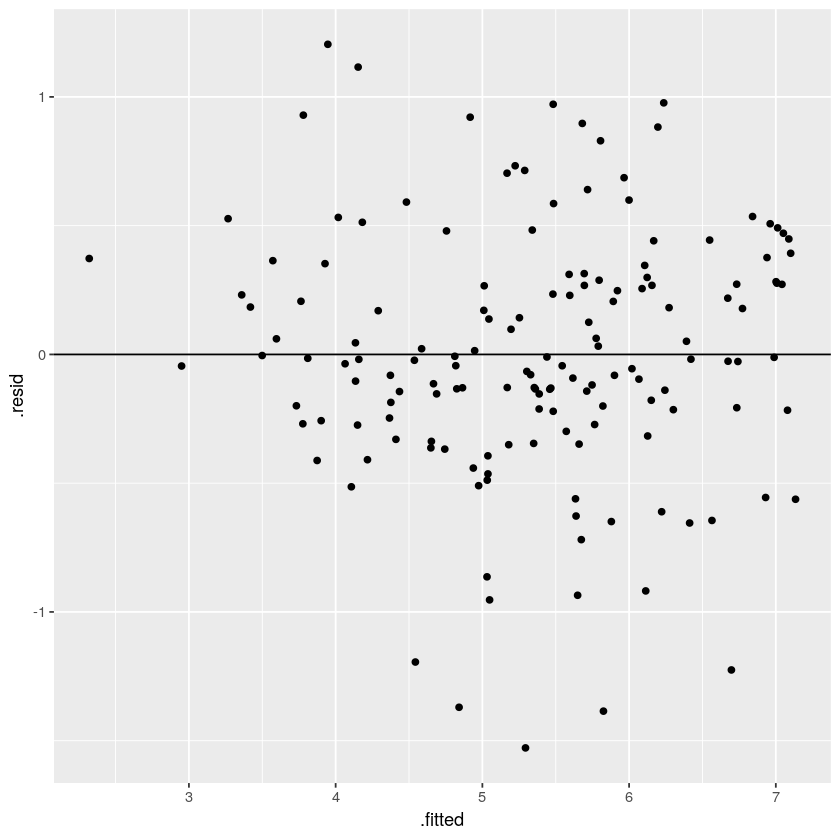

In [14]:
ggplot(mod, aes(x = .fitted, y = .resid)) + geom_point() + geom_hline(yintercept = 0)

Considering the summary that we calculated in part c we can see the residuals have a median of-.02277. This is relatively low so we can say that linear regression is most likely a good fit which satisfies condition 1. Condition 2 is satisfied because the data was garnered in a way that gave independent observations. The third condition (that points are normally distributed about the line) appears to hold because if we look at the residual plot the points don't seem to have a preference to either side of y=0. Finally, Condition 4: equal variability about the fitted line appears to hold, though (again looking at the residual plot) we can see that the negative residuals appear to have slightly more extreme values, but this does not appear to be enough to violate the condition.

#### (h) Consider the reduced model with only GDP, life expectancy, and freedom. Is this model sufficient? Base your answer on some formal measure of "sufficient".

In [14]:
#Create smaller model
modSmall <- lm(Happiness.Score~Economy..GDP.per.Capita.+ Health..Life.Expectancy. + Freedom, data = data)
#print summary of small model
summary(modSmall)


Call:
lm(formula = Happiness.Score ~ Economy..GDP.per.Capita. + Health..Life.Expectancy. + 
    Freedom, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.67667 -0.33040  0.01689  0.36336  1.14781 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)                2.4554     0.1448  16.959  < 2e-16 ***
Economy..GDP.per.Capita.   1.2157     0.1975   6.156 6.43e-09 ***
Health..Life.Expectancy.   1.4123     0.3477   4.062 7.78e-05 ***
Freedom                    2.2575     0.3181   7.098 4.62e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5485 on 151 degrees of freedom
Multiple R-squared:  0.7695,	Adjusted R-squared:  0.7649 
F-statistic:   168 on 3 and 151 DF,  p-value: < 2.2e-16


It appears that this model is sufficient since it still explains 76.95% of the variance (based on the $R^2$ value) is still explained by the model, which is only a loss of about 4.3%.

Collinearity is sometimes a problem in regression. Collinearity occurs when predictors in a model are correlated. In a multiple regression model with correlated predictors, estimators/coefficients may change erratically in response to small changes in the model or the data. One measure of collinearity is called the *variance inflation factor*. For each predictor in the model, define

$$VIF_j = \frac{1}{1-R_j^2},$$

where $R_j^2$ is the coefficient of determination for the model where the $j^{\text{th}}$ predictor is regressed against all the other predictors. The idea is that, if the $j^{\text{th}}$ predictor has a strong linear relationship with the other predictors, $R_j^2$ would be close to 1, and the variance inflation factor would be large. A rule of thumb is that, if $VIF_j >10$, collinearity might be a problem worthy of further investigation. (How do you investigate further? Take STAT 5010 to find out!).

#### (i) Load the ${\tt car}$ library into R and use the ${\tt vif()}$ function to decide whether collinearity is a problem for the full regression model fit above.

In [16]:
library(car)
vif(mod)

Economy..GDP.per.Capita.                        Family 
                     4.566281                      2.077338 
     Health..Life.Expectancy.                       Freedom 
                     3.582433                      1.627405 
                   Generosity Trust..Government.Corruption. 
                     1.214765                      1.494767

Colinearity appears to not be a problem because all of the VIF values are less than 10

## Problem 3

In this question, we will explore a method for fitting a regression model where the predictor variable is partitioned into intervals, and on each interval, a different linear relationship exists between the predictor and response. We are interested in fitting separate line segments to each interval such that the overall model is a continuous function.



#### (a) Load the ${\tt plant}$ dataset into R. Plot measurements of the plant organ, $y$, as a function of time, ${\tt time}$, using colors to differentiate attributes of the plant organ, ${\tt group}$.  


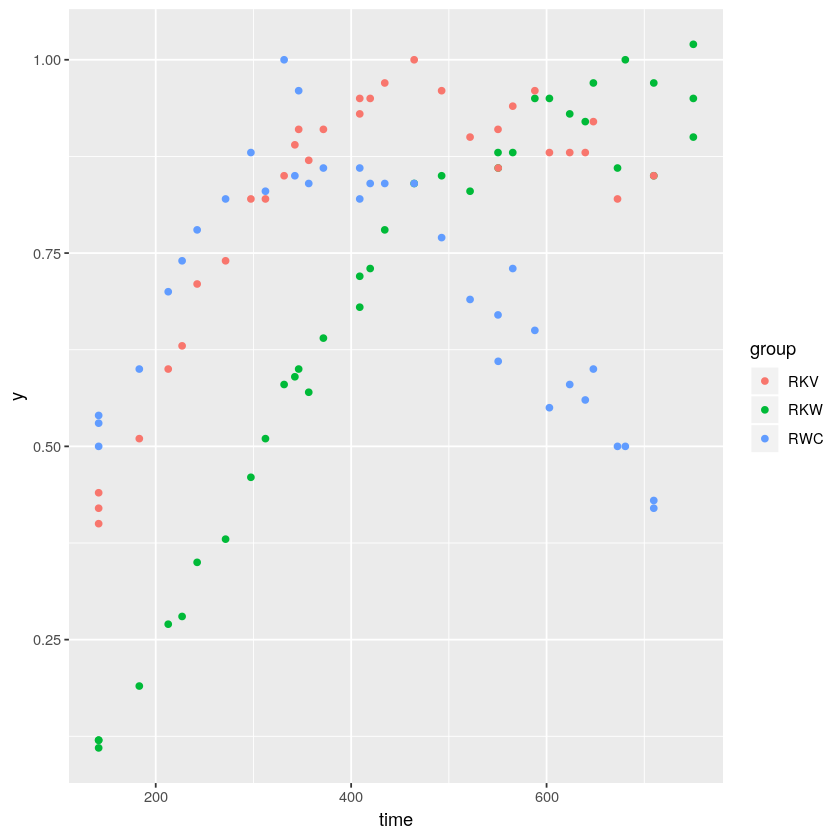

In [17]:
#load the data
data = read.delim("plant.txt", header = TRUE, sep = "\t")
#construct the plot of y vs time colored by group
ggplot(data, aes(x = time, y = y, color = group))+geom_point()

Notice that, conditioned on RKV, the time variable seems to be partitioned into two groups: a group where time is less than 400, and a group where time is greater than 400. We will fit the following model:

$$Y_i = \beta_0 + \beta_1f_1(X_i) + \beta_2f_2(X_i) + \varepsilon_i, \,\,\, i = 1,...,n, \,\,\,\,\,\, (1) $$

where:

1. $\varepsilon_i \sim \mathcal{N}(0, \sigma^2)$;

2. $
f_1(X) = 
\begin{cases}
400 - X \,\,\, \text{ if }  \,\,\, X \le 400 \\
0 \,\,\, \text{otherwise}
\end{cases};
$

3. $
f_2(X) = 
\begin{cases}
 X - 400 \,\,\, \text{ if }  \,\,\, X \ge 400 \\
0 \,\,\, \text{otherwise}
\end{cases};
$

4. $X$ is the time variable for group RKV; and

5. $Y$ is the measurement variable for group RKV.

#### (b) This model fits separate lines to the data before and after the "change point" of $400$. Write R code for the functions $f_1(x)$ and $f_2(x)$. 

In [18]:
#description: returns 400-x if x<=400 and 0 otherwise
#@param x: determines the return value
f1 <- function(x){
    output = rep(0, length(x))
    for(i in 1:length(x)){
        if(x[i]<=400){
            output[i] = 400-x[i]
        }else{
            output[i] = 0
        }
    }
    return(output)
}

#description: returns x-400 if x>=400 and 0 otherwise
#@param x: determines the return value
f2 <- function(x){
    output = rep(0, length(x))
    for(i in 1:length(x)){
        if(x[i]>=400){
            output[i] = x[i]-400
        }else{
            output[i] = 0
        }
    }
    return(output)
}
#since this model is only applicable for the RKV group we will filter for that group
data <- data%>%
filter(group == "RKV")

#### (c) Using the model in (1), write down the equation of the line that is fit to the data to the left of the change point. Write down the equation of the line that is fit to the data to the right of the change point. Justify your answers.

The one to the left:
$$
Y_i=\beta_0+\beta_1*(400-X)+\epsilon_i
$$
Because $f_2$ will be 0 to the left of the change point leaving us with just the intercept, the $f_1$ expression and the error  

The one to the right:
$$
Y_i=\beta_0+\beta_2*(X-400)+\epsilon_i
$$
Because $f_1$ will be 0 to the left of the change point leaving us with just the intercept, the $f_2$ expression and the error 

#### (d) Fit the model in (1) in R, and print a summary. Should you exclude any of the (transformed) predictors from the model? Would a model with just an intercept be sufficient? Explain why or why not?

In [19]:
#construct our model with the transformed parameters
model = lm(y~f1(time)+f2(time), data = data)
summary(model)


Call:
lm(formula = y ~ f1(time) + f2(time), data = data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.059054 -0.024047 -0.000161  0.023438  0.057910 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.871e-01  1.122e-02  87.981  < 2e-16 ***
f1(time)    -2.104e-03  8.065e-05 -26.090  < 2e-16 ***
f2(time)    -4.524e-04  7.109e-05  -6.364  5.9e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03307 on 29 degrees of freedom
Multiple R-squared:  0.9646,	Adjusted R-squared:  0.9622 
F-statistic: 395.1 on 2 and 29 DF,  p-value: < 2.2e-16


While both the coefficients for our transformed parameters are small, we cannot ignore them, because of the scale of both y and time. Time appears to go until 700, meaning that any slope even in magnitude $10^{-3}$ might have an affect on the predictions (since we are in the $10^2$ magnitude range the $10^{-3}$ slope would actually be around $10^{-1}$, even though we are adjusting both variables by 400). Then if we look at the scale of y we see that it is almost always below one, so even decimal points of slope may affect the result significantly (meaning we cannot ignore slopes of magnitude $10^{-4}$ since this will be around .01 for some values) so both the slopes should be significant for predicting this funcition. For this reason using just the intercept will not be sufficient for this problem (even though the intercept is much larger).  

The other problem with only using the intercept in this model is that the data clearly shows that a horizontal line will not be as good a fit as the set of diagonal lines created by our model.

#### (e) Plot the model over the scatterplot of the data. Comment on the fit.

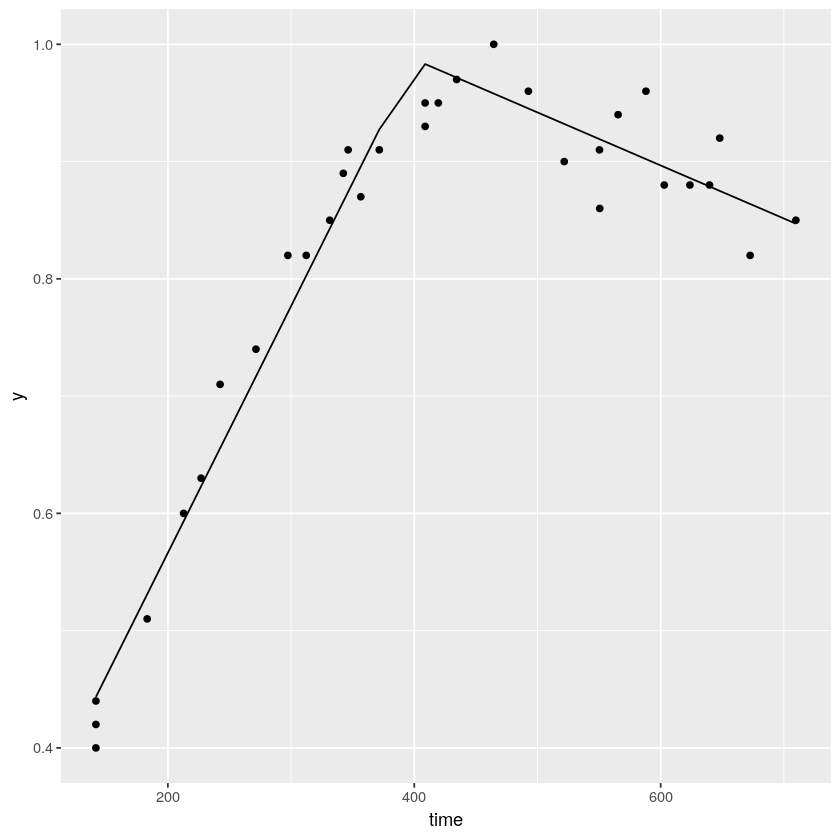

In [20]:
#get our model's predictions on the data itself
pred = predict(model)
#plot the scatter plot of the data, and the fitted line
ggplot(data, aes(x = time, y = y)) + geom_point() + geom_line(data = data, aes(x = time, y = pred))

The fit seems good in this case, which we might have guessed because we got an $R^2$ value of around .96 for this model.

#### (f) Plot the residuals against the fitted values. Comment on this plot. 

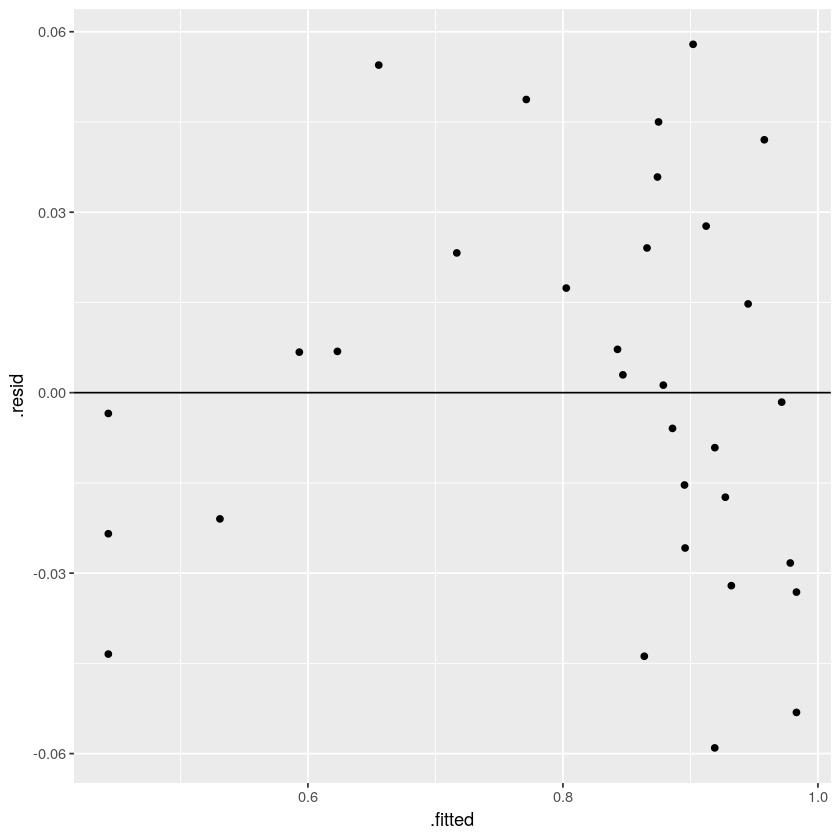

In [21]:
ggplot(model, aes(x = .fitted, y = .resid)) + geom_point() + geom_hline(yintercept = 0)

This distribution looks a little U shapped, so perhaps anohter fit to try would be using a squared feature. 

## Problem 4

In this class, we used the *frequentist* (or *classical*) paradigm in statistics to make inferences about a population parameter based on sample information. Many have criticized this paradigm, and much of that criticism comes from so-called *Bayesian* statisticians. The Bayesian paradigm provides another way for us to make inferences about a population parameter based on sample information. In this question, we will explore the differences in these paradigms, and learn a bit about the Bayesian paradigm.


#### (a) Conduct some research on the differences between the frequentist and Bayesian statistical paradigms, and summarize your research here (a few paragraphs will be necessary). [This article](https://plato.stanford.edu/entries/statistics/#ClaSta) might be a nice start. In particular, what do the differences here have to do with *conceptual/philosophical* issues (rather than *empirical/scientific* issues)? What do the differences have to do with the interpretation of probability theory?

The most striking difference between bayesian and frequentist phiosophies, to me, was seen in how they each handle confidence/credible intervals. In frequentist confidence intervals we imagine drawing a population of confidence intervals, and the level of confidence determines how often the drawn confidence interval will contain the parameter that we are measuring. In Bayesian reasoning we wouldn't need to think of a population of intervals at all. Credible intervals are the Bayesian take on confidence intervals. They make no statments about how often the interval contains the "true parameter value", they simply encapsulate the idea of our belief in a particular set of parameters. A 95% credible interval says that there is a .95 probability that the true value falls in said interval. This is a subtle distinction, in bayesian reasoning we are using probability to make a claim about how much we believe certain parameters are the true population parameter. Frequentist philosophy makes no claim about belief, rather it thinks of probability as a long term behavior, and considers belief as something akin to "well after many simulations/across a population I will be right much more than I am wrong". Bayesian statistics incorperates for some kind of belief that a given parameter choice is correct, whereas frequentist statistics is only trying to be right more often than it is wrong for many simulations.  

Another interesting difference between Baysian and frequentist statistics is the idea of a prior belief. Consider a signal processing problem where we recieve a signal and must find the point that it originated (like a radar). A frequentist would have no prior belief of where the signal might lie, so it simply follows that signal. A Baysian statistian would have data on where signals had been transmitted from in the past, and they could incoorperate this into their statistical analysis. Fundamentally, frequentist statisticians do not take into account a prior belief about a statistic into their analysis while Baysian statisticians do.

As you've (hopefully) noted above, Bayesians assign a posterior probability distrubution to values of a parameter, given sample information. From this posterior, we can find point estimates (e.g., the mean of the posterior) and interval estimates (intervals along the posterior distribution containing the parameter with a specified probability). 

Consider $n = 15$ independent flips of a coin. The probability of heads, $p$, is unknown to us, and we'd like to infer something about it. We can do this with Bayes' theorem! Let $X_1,...,X_n$ represent our flips ($X_i = 1$ if heads, 0 if tails). Bayes' theorem states that:

$$\pi( p \, | \, X_1,...,X_n) = \frac{L( X_1,...,X_n \, | \, p)\pi(p)}{\pi(X_1,...,X_n)},$$ 

where $\pi( p \, | \, X_1,...,X_n)$ is the posterior probability distribution for $p$ given the data, $L( X_1,...,X_n \, | \, p)$ is the likelihood function for the data, $\pi(p)$ is the prior probability distribution on $p$, and $\pi(X_1,...,X_n)$ is the "evidence" (which can be calculated using the law of total probability). 

Let's construct a simplified version of Bayesian inference.

#### (b) First, descretize the parameter space by making a grid of $m = 100$ values for $p$ between 0 and 1. Then, create a vector of prior probabilities that assigns equally likely probabilities to each value of $p$.

In [42]:
#record the number of points in our parameter space
m = 100
#create a sequence of linearly spaced parameters
paramSpace = seq(0, 1, length.out = m)
#prior is the same for all parameters
prior = rep(1/m, m)

#### (c) We flip the coin 15 times, and count 4 heads. Calculate the probability of getting 4 heads in 15 tosses under each value of $p$  given above. These are values of the likelihood function.

In [43]:
#set the number of heads in our data
headsCount = 4
#initialize our vector of likelihoods
probs = rep(0, m)
#populate our probs vector with the likelihoods of observing the data given the ith parameter in the parameterspace
for(i in 1:length(paramSpace)){
    probs[i] = choose(15,4)*paramSpace[i]^headsCount*(1-paramSpace[i])^(15-headsCount)
}


#### (d) Use Bayes' theorem and the information from previous parts to calculate the posterior distribution for each of the 100 values of $p$. Plot and describe the posterior distribution. In particular, does it look like a distribution that we've studied in class?

[1] 1

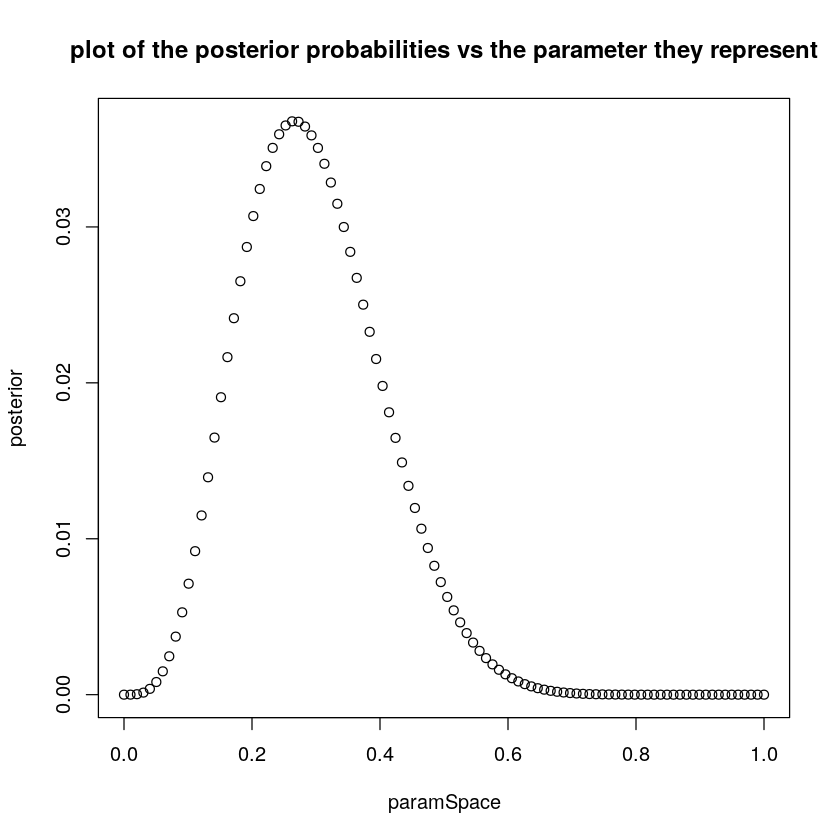

In [44]:
#find the p(data that we observed) using the law of total probability
evidence = sum(probs*prior)
#calculate the posterior distribution
posterior = probs*prior/evidence
#plot the posterior
plot(paramSpace,posterior, main = "plot of the posterior probabilities vs the parameter they represent")

This distribution is unimodal with a skew to the right and it is asymmetric. This distribution looks approximently normal, but it is right skewed and asymmetric. This might be closer to a T-distribution since it has a long tail, but because it is not symmetric its tough to say.

#### (e) Find a reasonable point estimate for $p$. A $(1-\alpha)\times 100\%$ *Bayesian credible interval* is a range of values within which the parameter value falls with probability $1 - \alpha$.  Use the posterior distribution found in (d) to find a 95% credible interval for $p$. 

Results from a simulation which assumes the above is a normal distribution

In [45]:
#Assume the distribution is actually normal
#use simulation to get the parameters of this normal
#set for reproducability
set.seed(10)
#create a vector of 1000000 samples from our parameter space, each with probability equal to the posterior that we
#just calculated
vecOfSamples = sample(x = paramSpace, size = 1000000, replace = TRUE, prob = posterior)
#get the parameters of the normal distribution
meanPos = mean(vecOfSamples)
sdPos = sd(vecOfSamples)
#-------------
#for a normal distribution we know that 95% of the data is within 2 standard deviations of the mean, so this will
#comprise our credible interval
lower = meanPos-2*sdPos
upper = meanPos+2*sdPos

#print our credible interval
print("The 95% credible interval is:")
print(lower)
print("to")
print(upper)

[1] "The 95% credible interval is:"
[1] 0.0794199
[1] "to"
[1] 0.5085782


The above does not account for skew, and after talking with the professor in office hours I have a better solution:

In [46]:
#look at the indicies of the cumulative sum of the posterior, we are interested in the indeices when the 
#cumulative sum of the posterior is less than .025 and when they are greater than .975. for the left bound we want
#the highest index and for the upper bound we want the lowest index
credInt = c(max(paramSpace[cumsum(posterior) < .025]), min(paramSpace[cumsum(posterior)>.975]))
print("More accurate credible interval")
print(credInt)

[1] "More accurate credible interval"
[1] 0.1010101 0.5252525


#### (f) Interpret this interval. How does the interpretation compare to the interpretation for a confidence interval for $p$? Which interpretation do you prefer?

This means that there is a probability of .95 that the true parameter of interest (in this case the probability of the coin landing heads) is in this interval. This is different from a confidence interval because a confidence interval says that after many simulations the true parameter for p will be within the generated confidence interval 95% of the time, meaning a credible interval gives a direct probability, so it makes its claim in isolation of other simulations/members of a population, and a confidence interval can only make its claim in the context of other simulations/members of a population. One way to think about this is frequentist statisticians think of confidence intervals as a random variable (one that can be simulated), and bayesian statisticians think credible intervals as a sort of probability. I personally prefer the Bayesian interpretation, because it is closer to the colloquial idea of probability, where probability is more of a statement of belief rather than the long term behavior of some system.

## Problem 5

Here, let's redo the previous problem in a more rigorous way. A modified version of Bayes' theorem states that:

$$\pi( p \, | \, X_1,...,X_n) \propto L( X_1,...,X_n \, | \, p)\pi(p),$$ 

where the functions are the same as above, and $\propto$ is read as "proportional to". In some special cases, it is relatively easy to use this version of Bayes' theorem to find the exact form of the posterior probability distribution for $p$.


#### (a) Write down the likelihood function for the coin example. The likelihood is defined as the (joint) pmf/pdf of the data, interpreted as a function of the parameter (in this case, $p$). For some help, see the solutions to homework #8, question 7, where you found a likelihood function for normal iid data.


We are interested in $L(X_1,...,X_n|p)$ where each variable $X_i$ takes a value of 1 with probability p and 0 with probability 1-p. This means that given a fixed parameter p we have:
$$
L(X_1|p) = p^{X_1}*(1-p)^{1-X_1}
$$
Then, by independence we get:
$$
L(X_1,...,X_n|p) = p^{\sum_{i=1}^nX_i}*(1-p)^{n-\sum_{i=1}^nX_i}
$$

#### (c) We will use a beta prior distribution on $p$. Write down the pdf of the beta distribution and briefly justify why it is a reasonable choice for a prior distribution in this example. 


The pdf of the beta distrubtuion is:
$$
Beta(x;\alpha,\beta)=\frac{x^{\alpha-1}(1-x)^{\beta-1}\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}
$$
where $\Gamma(x)$ is defined as $\Gamma(x) = \int_{0}^{\infty} z^{x-1}exp(-z)dz$. This is a reasonable choice because if we ignore all of the gamma functions this looks almost exactly the same as the binomial distribution, so one could reasonibly interpret this distribution as a sort of analog to the binomial distribution (just with a different normalization term). The difference is that the Beta distribution is modeling the probability of success (see x in the pdf) where as the binomial is modeling the number of successes (see m in part a of this problem). So it would seem natural to model our prior belief about the distribution of p as this since the Beta distribution is already trying to model p. Because of this intuition we can also note that the beta distribution is only defined from 0 to 1, so it can model probabilities.

#### (d) Compute the posterior distribution, up to the normalizing constant, using Bayes' theorem. This means you can omit all normalizing constants from your calculation. Is this posterior distribution of a particular type (e.g., normal, exponential, beta, binomial, etc.)?


$$
\begin{align}
\pi( p \, | \, X_1,...,X_n) &\propto p^{\sum_{i=1}^nX_i}*(1-p)^{n-\sum_{i=1}^nX_i}*Beta(x;\alpha, \beta)\\
&= p^{\sum_{i=1}^nX_i}*(1-p)^{n-\sum_{i=1}^nX_i}p^{\alpha-1}(1-p)^{\beta-1}\\
&=p^{\alpha-1+\sum_{i=1}^nX_i}*(1-p)^{\beta-1+n-\sum_{i=1}^nX_i}
\end{align}
$$
This is a binomial distribution with out the normalization term (which we dropped in the beginning so this was expected)

#### (e) Suppose, again, that we flip our coin $n = 15$ times and get 4 heads. Compute,  plot, and interpret the posterior distribution for $p$.

[1] 8.412976e-06

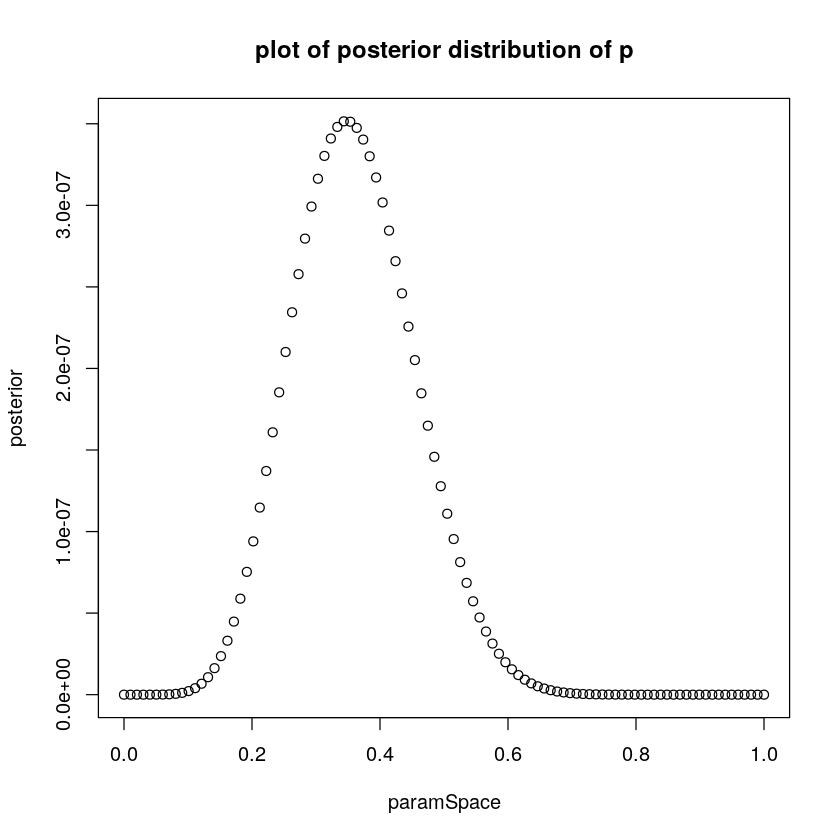

In [56]:
paramSpace = seq(0, 1, length.out = 100)
numHeads = 4
totalFlips = 15
alpha = 5
beta = 5
#calculate posterior
posterior = paramSpace^(alpha-1+numHeads)*(1-paramSpace)^(beta-1+totalFlips-numHeads)
plot(paramSpace, posterior, main = "plot of posterior distribution of p")
sum(posterior)

This distribtion is unimodal with a right skew, and the distribution is asymmetric (the right tail is longer than the left). This plot is the right shape, but it is off by a scaling factor, which is to be expected considering we removed all of the scaling factors when we dropped the normalizing constants when we calculatedthe distribution. Other than that it looks approximently normal as we would expect. Also note that this distribution changes location slightly when you adjust alpha and beta, I chose alpha = 5 and beta = 5 since this makes our prior belief unskewed (so we don't think that this is a biased coin originally), and because, after discussing it in office hours, it doesn't appear that alpha and beta change the distribution very much.

#### (f) Use the properties of the posterior distribution found in (e) to report a point estimate for $p$.

In order to estimate p we will maximize the posterior distribution (since this distribution respresents the probability of parameter p given the data we observe). So we would like to maximize:
$$
\begin{align}
\pi( p \, | \, X_1,...,X_n) &\propto p^{\alpha-1+\sum_{i=1}^nX_i}*(1-p)^{\beta-1+n-\sum_{i=1}^nX_i}
\end{align}
$$
Taking the derivative of the log of this function:
$$
\begin{align}
ln(\pi( p \, | \, X_1,...,X_n)) &= (\alpha-1+\sum_{i=1}^nX_i)ln(p)+(\beta-1+n-\sum_{i=1}^nX_i)ln(1-p)\\
ln(\pi( p \, | \, X_1,...,X_n))' &= \frac{(\alpha-1+\sum_{i=1}^nX_i)}{p}-\frac{(\beta-1+n-\sum_{i=1}^nX_i)}{1-p}\\
\end{align}
$$
Set this to zero to find critical points:
$$
\begin{align}
\frac{(\alpha-1+\sum_{i=1}^nX_i)}{p}-\frac{(\beta-1+n-\sum_{i=1}^nX_i)}{1-p}&=0\\
=>(\alpha-1+\sum_{i=1}^nX_i)(1-p)-(\beta-1+n-\sum_{i=1}^nX_i)(p) &=0\\
=>\alpha-1+\sum_{i=1}^nX_i-p(\alpha-1+\sum_{i=1}^nX_i+\beta-1+n-\sum_{i=1}^nX_i)&=0\\
=>p&=\frac{\alpha-1+\sum_{i=1}^nX_i}{\alpha + \beta-2+n}
\end{align}
$$
Since this is the only cirtical point we know that it must be a max since the above simulation shows that a max exists, so it must have a critical point associated with it (and since we only found a single critical point it must be the one associated with the max). But for completeness sake we will use the second derivative test to confirm:
$$
\frac{d^2}{dp^2}ln(\pi( p \, | \, X_1,...,X_n)) = -\frac{(\alpha-1+\sum_{i=1}^nX_i)}{p^2}+\frac{(\beta-1+n-\sum_{i=1}^nX_i)}{(1-p)^2}(-1)
$$
Since both of the terms of the second derivative are negative for all values of p we know that the critical point we found is a max. So, our point estimate of p is:
$$
p=\frac{\alpha-1+\sum_{i=1}^nX_i}{\alpha + \beta-2+n}
$$

#### (g) A $(1-\alpha)\times 100\%$ *Bayesian credible interval* is a range of values within which the parameter value falls with probability $1 - \alpha$.  Use the posterior distribution found in (e) to find a 95% credible interval for $p$.

In [57]:
#since we didn't rescale the posterior distribution when we derived it we will need to account for this (by fixing
#the total probability such that it is 1)
one = sum(posterior)
#get credible interval
credInt = c(max(paramSpace[cumsum(posterior) < .025*one]), min(paramSpace[cumsum(posterior)>.975*one]))
print("Credible interval:")
print(credInt)

[1] "Credible interval:"
[1] 0.1818182 0.5555556


#### (h) Interpret this interval. How does the interpretation compare to the interpretation for a confidence interval for $p$? Which interpretation do you prefer?

As in problem four: this means that there is a probability of .95 that the true parameter of interest (in this case the probability of the coin landing heads) is in this interval. This is different from a confidence interval because a confidence interval says that after many simulations the true parameter for p will be within the generated confidence interval 95% of the time, meaning a credible interval gives a direct probability, so it makes its claim in isolation of other simulations/members of a population, and a confidence interval can only make its claim in the context of other simulations/members of a population. One way to think about this is frequentist statisticians think of confidence intervals as a random variable (one that can be simulated), and bayesian statisticians think credible intervals as a sort of probability. I personally prefer the Bayesian interpretation, because it is closer to the colloquial idea of probability, where probability is more of a statement of belief rather than the long term behavior of some system.  

A quick note: this interval is different from the one in problem 4 becuase we used a different prior distribution.

## Problem 6

So far, in class, we've worked with response variables (dependent variables) that are continuous. In this example, we will work on "logistic regression", which allows us to model a categorical response.

(a) Read in the binary data from https://stats.idre.ucla.edu/stat/data/binary.csv. 

The dataset contains several columns which we can use as predictor variables:

gpa

gre score

rank or prestige of an applicant's undergraduate alma mater

The fourth column, admit, is our binary target variable. It indicates whether or not a candidate was admitted our not.


Store rank and admit as categorical variables/factors. Print a summary of the data. Note anything interesting.

In [15]:
#read the data
data = read.csv(url("https://stats.idre.ucla.edu/stat/data/binary.csv"))
#force rank and admit to be factor variables
data$rank = as.factor(data$rank)
data$admit = as.factor(data$admit)
#print the summary of the data
summary(data)

 admit        gre             gpa        rank   
 0:273   Min.   :220.0   Min.   :2.260   1: 61  
 1:127   1st Qu.:520.0   1st Qu.:3.130   2:151  
         Median :580.0   Median :3.395   3:121  
         Mean   :587.7   Mean   :3.390   4: 67  
         3rd Qu.:660.0   3rd Qu.:3.670          
         Max.   :800.0   Max.   :4.000          

One interesting feature of this summary is that the data set consists of more people that were not admitted than were admitted. Another thing to note is that the extremes of the rank variable are less common than the two middle values

(b) When analyzing a statistical model, it is often useful to use some of the data to train the model and some of the data to test whether the model can make good predictions. Use the sample function to extract 20% of the data as a test set. Store the training data in a data frame called df_train, and the test data in a data frame called df_test.

In [16]:
#Get the test indicies
indiciesOfTest = sample(x = nrow(data), size = nrow(data)*.2)

#using the indicies of our test set set the test and train dataframes
df_test = data[indiciesOfTest,]
df_train = data[-indiciesOfTest,]

(c) Using the training data frame, and considering admit as the response with gre and gpa as predictors, run a logistic regression. Logistic regression in R can be run using the function glm(). For the family argument in glm(), use binomial. This specifies the mean model

$$ p = \frac{e^{\beta_0 + \beta_1X_1 + \beta_2X_2}}{1 + e^{\beta_0 + \beta_1X_1 + \beta_2X_2}}, $$

where $p$ is the probability of admittance. 
Report the summary of the logistic regression model. Interpret the coefficient associated with gpa.

In [17]:
#create the model using only the train set
model = glm(admit~gpa+gre+rank, data = df_train, family = binomial)
summary(model)


Call:
glm(formula = admit ~ gpa + gre + rank, family = binomial, data = df_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6783  -0.8869  -0.6317   1.1250   2.0453  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.128673   1.269516  -3.252  0.00115 ** 
gpa          0.950300   0.368778   2.577  0.00997 ** 
gre          0.002205   0.001201   1.837  0.06626 .  
rank2       -1.030106   0.359804  -2.863  0.00420 ** 
rank3       -1.518649   0.389764  -3.896 9.77e-05 ***
rank4       -1.782741   0.456468  -3.906 9.40e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 409.19  on 319  degrees of freedom
Residual deviance: 369.97  on 314  degrees of freedom
AIC: 381.97

Number of Fisher Scoring iterations: 4


The coefficients of logistic regression affect the log odds of the admit variable. This means that that gpa for every increase of 1 in GPA we would expect an increase of .668477 in the log odds of being admitted after controlling for gre score and rank. This is somewhat difficult to interpret so we will convert it to a regular odds interpretation of the coefficient by exponentiating the coefficient. Since exp(.668477) is approximently equal to 1.95126 we could also interpret the gpa coefficient as an expected 95% increase in the odds of admittance for every gpa point increase after controlling for gre score and rank.

(d) Use the model to predict whether the people in the test set were admited to graduate school or not. Then, calculate the accuracy of these predictions. What percent of predictions are correct?

In [18]:
#get our predictions on the testing data
predictions = predict(model, newdata = df_test)
#if odds are > 0 say we predict admittance
for(i in 1:length(predictions)){
    if(predictions[i] > 0){
        predictions[i] = 1
    }else{
        predictions[i] = 0
    }
}
#set a variable to keep track of the actual values of the test set
realVals = data$admit[indiciesOfTest]
#variable to keep track of the number of correct predictions
numCorrect = 0
#get an accuracy score:
for(i in 1:length(predictions)){
    if(predictions[i] == realVals[i]){
        numCorrect = numCorrect + 1
    }
}
#get the proportion of correct predictions
accuracyScore = numCorrect/length(predictions)
print("Our accuracy was:")
print(accuracyScore)
print("As a percent:")
print(100*accuracyScore)

[1] "Our accuracy was:"
[1] 0.7125
[1] "As a percent:"
[1] 71.25
